# Install Darts

In [1]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.7/884.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.8/121.8 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.5/193.5 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1

# Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from darts import TimeSeries

## Helper Functions

In [4]:
def load_csv_day_ahead_prices(year):
  region = 3

  df = pd.read_csv(f'dap-se{region}-{year}.csv')
  df.index = pd.to_datetime(
    df['MTU (CET/CEST)'].str.split(' - ').str[0],
    format='%d.%m.%Y %H:%M'
  )
  df.drop(
    columns=['MTU (CET/CEST)', f'BZN|SE{region}', 'Currency'],
    inplace=True
  )

  return df

def day_ahead_prices(start=2015, end_incl=2023):
  region = 3

  df = pd.concat([load_csv_day_ahead_prices(year) for year in range(start, end_incl + 1)])
  df = df.ffill()
  df = df[~df.index.duplicated(keep='first')]

  return df

In [5]:
def load_csv_total_load_forecast(year):
  region = 3

  df = pd.read_csv(f'tl-se{region}-{year}.csv')
  df.index = pd.to_datetime(
    df['Time (CET/CEST)'].str.split(' - ').str[0],
    format='%d.%m.%Y %H:%M'
  )
  df.drop(
    columns=['Time (CET/CEST)', f'Actual Total Load [MW] - BZN|SE{region}'],
    inplace=True
  )
  df.rename(
    columns={ f'Day-ahead Total Load Forecast [MW] - BZN|SE{region}': 'Day-ahead Total Load Forecast [MW]' },
    inplace=True
  )

  return df

def total_load_forecast(start=2015, end_incl=2023):
  region = 3

  df = pd.concat([load_csv_total_load_forecast(year) for year in range(start, end_incl + 1)])
  df = df.ffill()
  df = df[~df.index.duplicated(keep='first')]

  return df

In [6]:
def load_csv_total_load_actual(year):
  region = 3

  df = pd.read_csv(f'tl-se{region}-{year}.csv')
  df.index = pd.to_datetime(
    df['Time (CET/CEST)'].str.split(' - ').str[0],
    format='%d.%m.%Y %H:%M'
  )
  df.drop(
    columns=['Time (CET/CEST)', f'Day-ahead Total Load Forecast [MW] - BZN|SE{region}'],
    inplace=True
  )
  df.rename(
    columns={ f'Actual Total Load [MW] - BZN|SE{region}': 'Actual Total Load [MW]' },
    inplace=True
  )

  return df

def total_actual_load(start=2015, end_incl=2023):
  region = 3

  df = pd.concat([load_csv_total_load_actual(year) for year in range(start, end_incl + 1)])
  df = df.ffill()
  df = df[~df.index.duplicated(keep='first')]

  return df

In [7]:
# SMHI files are cut to range from 2015-2023
def load_smhi(filename):
  df = pd.read_csv(filename, delimiter=';', quoting=3)
  df.index = pd.to_datetime(
    df['Datum'] + " " + df['Tid (UTC)'],
    format='%Y-%m-%d %H:%M:%S'
  )
  df.drop(
    columns=['Datum', 'Tid (UTC)', 'Kvalitet'],
    inplace=True
  )
  df = df.resample('1H').asfreq()
  df = df.ffill()
  df = df[~df.index.duplicated(keep='first')]
  return df

# Visualizing the Data

<Axes: xlabel='MTU (CET/CEST)'>

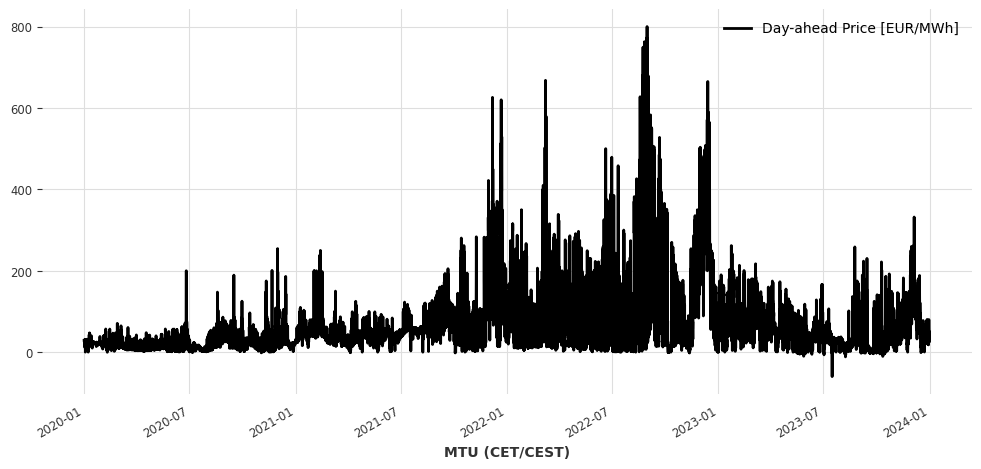

In [8]:
start_year = 2020
end_year = 2023

df = day_ahead_prices(start=start_year, end_incl=end_year)
series = TimeSeries.from_dataframe(df)

plt.figure(figsize=(12,5))
series.plot()

## Zooming in on a Month for Detail View

(19052.0, 19083.0)

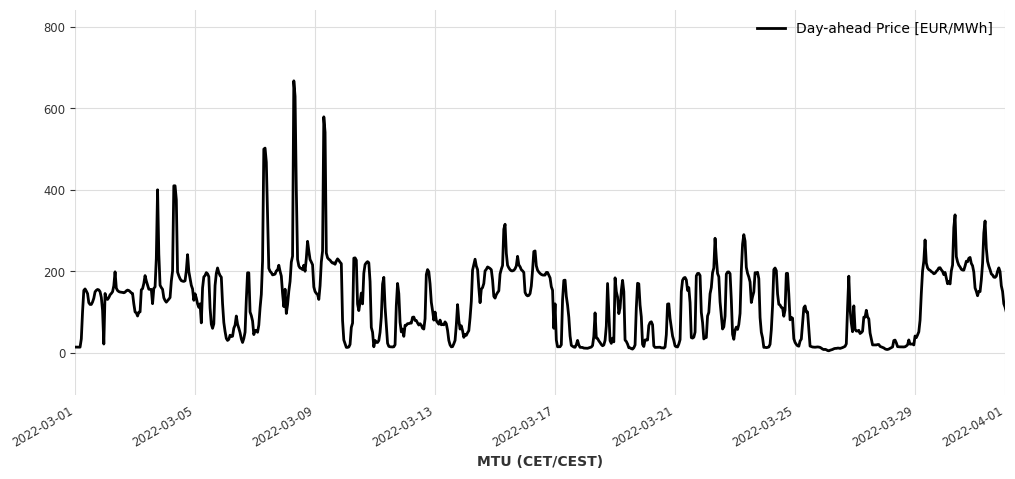

In [10]:
plt.figure(figsize=(12, 5))
series.plot()
plt.xlim(
  left=series.start_time() + pd.DateOffset(years=2, months=2),
  right=series.start_time() + pd.DateOffset(years=2, months=3)
)

# Data Processing
A mirror-logarithmic transform has been used instead of a normal logarithm to account for the infrequent negative prices.

In [11]:
import numpy as np

class MLogScaler:
  def __init__(self, c = 1 / 3):
    self.c = c

  def fit(self, X):
    return self

  def transform(self, X):
    return np.sign(X) * (np.log(1 / self.c + np.abs(X)) + np.log(self.c))

  def inverse_transform(self, X):
    return np.sign(X) * (np.exp(np.abs(X) - np.log(self.c)) - 1 / self.c)

<Axes: xlabel='MTU (CET/CEST)'>

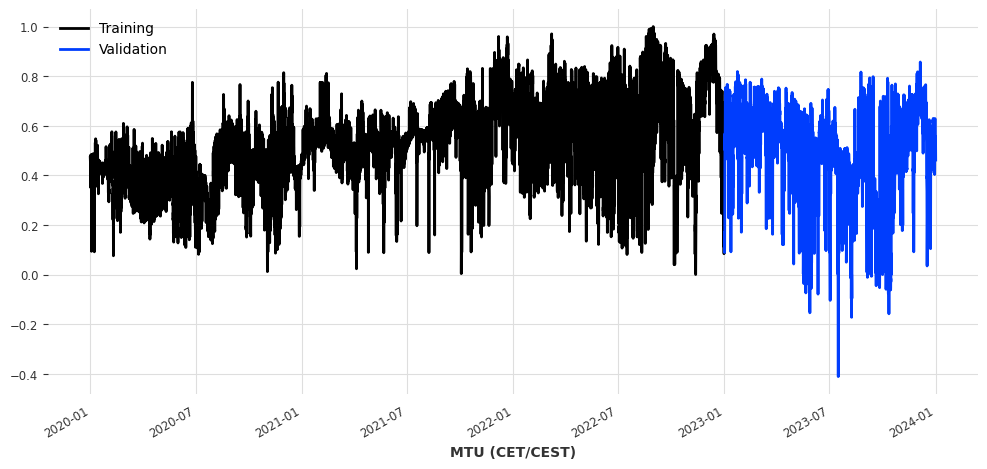

In [12]:
from darts.dataprocessing.transformers import Scaler

cutoff = pd.Timestamp(f'{end_year}-01-01')
train, val = series.split_before(cutoff)

mlog = Scaler(scaler=MLogScaler())
train_mlog = mlog.fit_transform(train)
val_mlog = mlog.transform(val)
series_mlog = mlog.transform(series)

compress = Scaler()
train_transformed = compress.fit_transform(train_mlog)
val_transformed = compress.transform(val_mlog)
series_transformed = compress.transform(series_mlog)

plt.figure(figsize=(12, 5))
train_transformed.plot(label='Training')
val_transformed.plot(label='Validation')

# Covariates
We'll be using the actual load and weather conditions in the specified area

## Predicted Load
The predicted load covariate already has a lot of covariates essentially "built in" to it. This can be used as a future covariate, but the BlockRNNModel does not support it.

<Axes: xlabel='Time (CET/CEST)'>

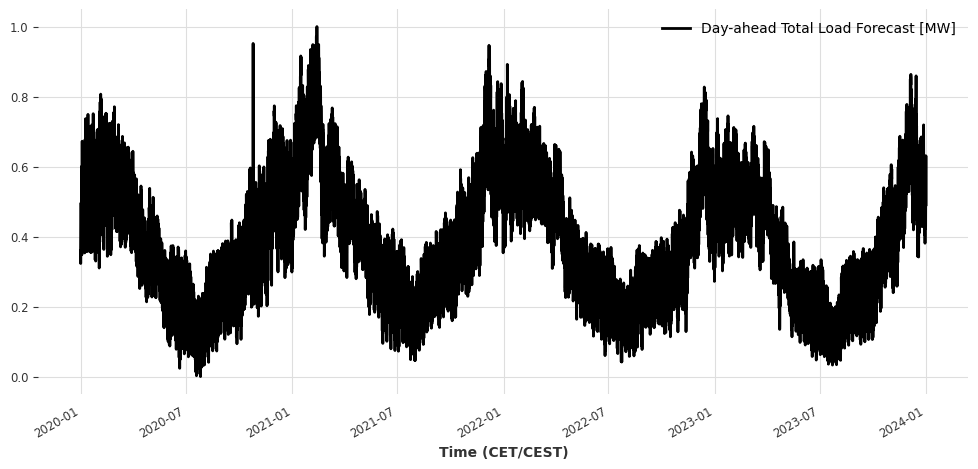

In [13]:
predicted_load_series = TimeSeries.from_dataframe(total_load_forecast(start=start_year, end_incl=end_year))

predicted_load_series = Scaler().fit_transform(predicted_load_series)

plt.figure(figsize=(12, 5))
predicted_load_series.plot()

## Actual Load

<Axes: xlabel='Time (CET/CEST)'>

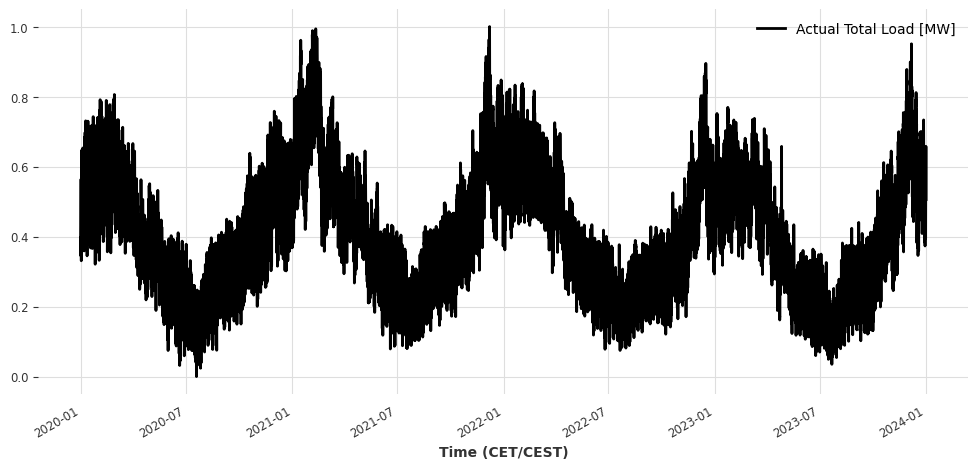

In [14]:
actual_load_series = TimeSeries.from_dataframe(total_actual_load(start=start_year, end_incl=end_year))

actual_load_series = Scaler().fit_transform(actual_load_series)

plt.figure(figsize=(12, 5))
actual_load_series.plot()

## Date-Time Features

(18256.0, 18303.0)

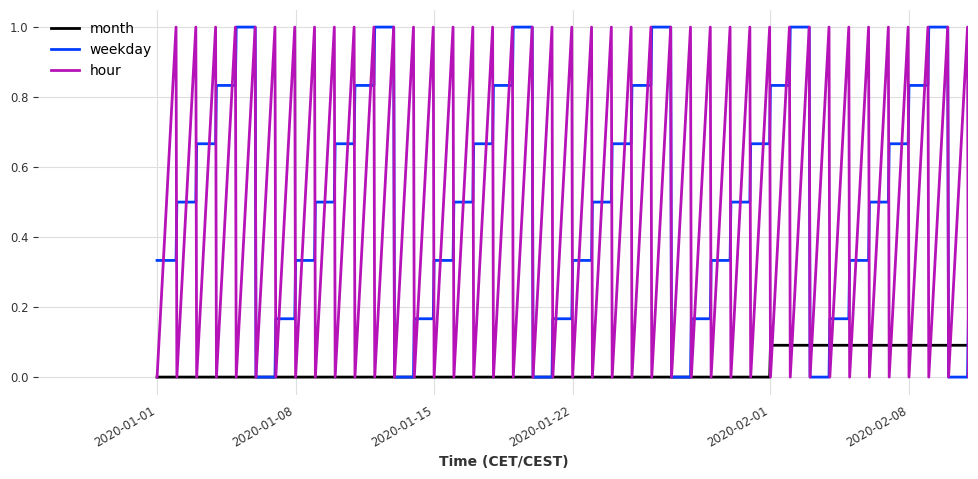

In [15]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries

month_series = datetime_attribute_timeseries(
  predicted_load_series,
  attribute="month"
)
month_series = Scaler().fit_transform(month_series)

weekday_series = datetime_attribute_timeseries(
  month_series,
  attribute="weekday"
)
weekday_series = Scaler().fit_transform(weekday_series)

hour_series = datetime_attribute_timeseries(
  weekday_series,
  attribute="hour"
)
hour_series = Scaler().fit_transform(hour_series)

datetime_series = month_series.stack(weekday_series).stack(hour_series)

plt.figure(figsize=(12, 5))
datetime_series.plot()
plt.xlim(
  left=datetime_series.start_time() - pd.DateOffset(days=6),
  right=datetime_series.start_time() + pd.DateOffset(months=1, days=10)
)

## Weather Conditions
- Wind speeds and temperature are taken from Bromma Airport (BMA).
- Solar radiation is taken from Stockholm Sol.

(18262.0, 18322.0)

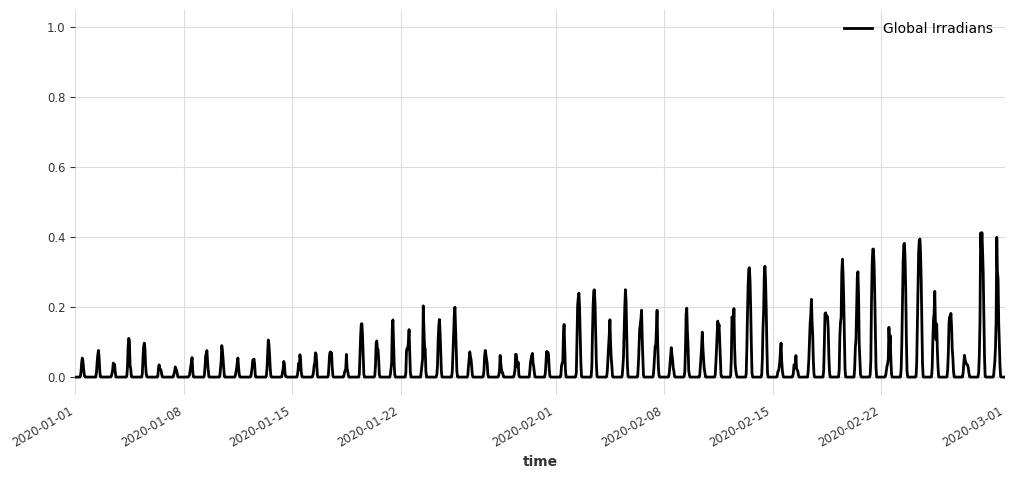

In [22]:
solar_df = load_smhi('smhi-solar-radiation-stockholmsol.csv')

solar_series = TimeSeries.from_dataframe(solar_df)
solar_series = solar_series.drop_before(pd.Timestamp(f'{start_year - 1}-12-31 23:59'))
solar_series = Scaler().fit_transform(solar_series)

plt.figure(figsize=(12, 5))
solar_series.plot()
plt.xlim(left=solar_series.start_time(), right=solar_series.start_time() + pd.DateOffset(months=2))

(18262.0, 18322.0)

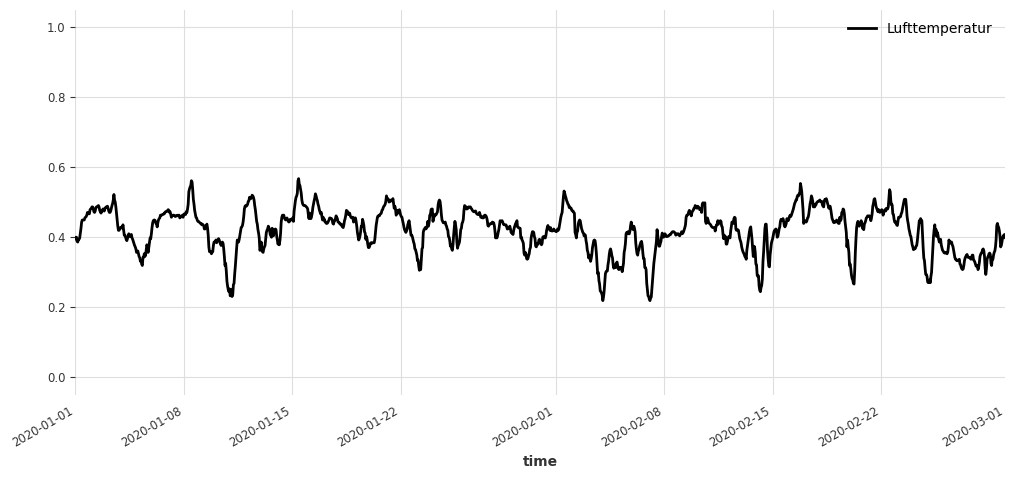

In [23]:
temperature_df = load_smhi('smhi-temperature-bma.csv')

temperature_series = TimeSeries.from_dataframe(temperature_df)
temperature_series = temperature_series.drop_before(pd.Timestamp(f'{start_year - 1}-12-31 23:59'))
temperature_series = Scaler().fit_transform(temperature_series)

plt.figure(figsize=(12, 5))
temperature_series.plot()
plt.xlim(left=temperature_series.start_time(), right=temperature_series.start_time() + pd.DateOffset(months=2))

(18262.0, 18322.0)

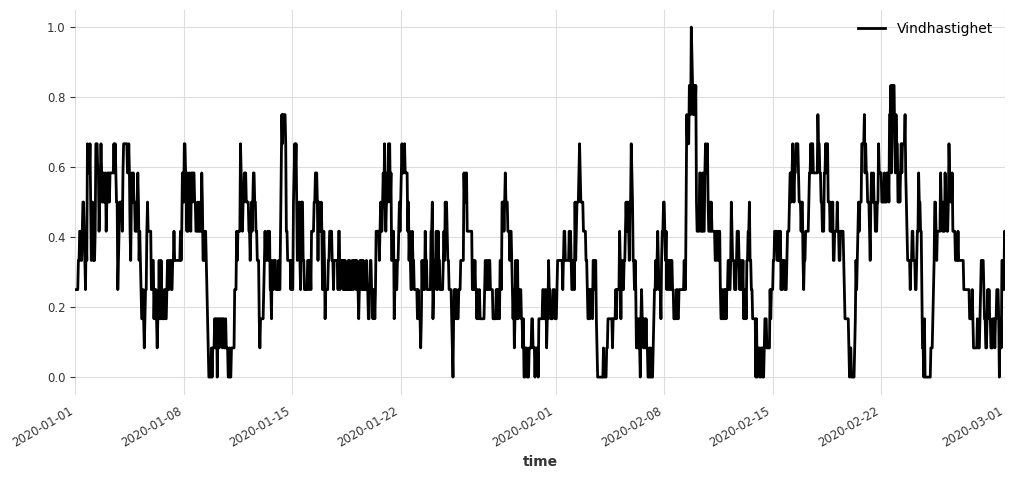

In [24]:
windspeed_df = load_smhi('smhi-windspeed-bma.csv').drop(columns=['Vindriktning', 'Kvalitet.1'])

windspeed_series = TimeSeries.from_dataframe(windspeed_df)
windspeed_series = windspeed_series.drop_before(pd.Timestamp(f'{start_year - 1}-12-31 23:59'))
windspeed_series = Scaler().fit_transform(windspeed_series)

plt.figure(figsize=(12, 5))
windspeed_series.plot()
plt.xlim(left=windspeed_series.start_time(), right=windspeed_series.start_time() + pd.DateOffset(months=2))

In [25]:
weather_series = solar_series.stack(temperature_series).stack(windspeed_series)

covariates_past = actual_load_series.stack(predicted_load_series).stack(datetime_series).stack(weather_series)

# covariates_future = predicted_load_series.stack(datetime_series)

# Model Creation

In [26]:
from darts.models import BlockRNNModel
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.0001,
    mode='min',
)

lstm_model = BlockRNNModel(
  model='LSTM',
  n_epochs=100,

  n_rnn_layers=2,
  hidden_dim=64,
  input_chunk_length=48,
  output_chunk_length=24,

  dropout=0.15,
  batch_size=128,
  pl_trainer_kwargs={ 'callbacks': [early_stop] },

  optimizer_kwargs={ 'lr': 1e-3 },
  save_checkpoints=True,
  log_tensorboard=True,
  model_name='LSTM_DayAheadPrices',

  force_reset=True,
  random_state=42
)

lstm_model.fit(
  train_transformed,

  past_covariates=covariates_past,
  #future_covariates=covariates_future,

  val_series=val_transformed,
  val_past_covariates=covariates_past,
  #val_future_covariates=covariates_future,

  verbose=True
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 52.5 K
4 | fc            | Sequential       | 1.6 K 
---------------------------------------------------
54.0 K    Trainable params
0         Non-trainable params
54.0 K    Total params
0.216     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

BlockRNNModel(output_chunk_shift=0, model=LSTM, hidden_dim=64, n_rnn_layers=2, hidden_fc_sizes=None, dropout=0.15, n_epochs=100, input_chunk_length=48, output_chunk_length=24, batch_size=128, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x78f9250696f0>]}, optimizer_kwargs={'lr': 0.001}, save_checkpoints=True, log_tensorboard=True, model_name=LSTM_DayAheadPrices, force_reset=True, random_state=42)

# Prediction Time

In [27]:
def evaluate(model):
  historical_forecasts = model.historical_forecasts(
    series_transformed,
    start=val_transformed.start_time(),
    forecast_horizon=24,
    past_covariates=covariates_past,
    retrain=False,
    enable_optimization=True,
    verbose=True
  )

  plt.figure(figsize=(12, 5))
  series_transformed.plot(label='Actual')
  historical_forecasts.plot(label='Forecast')
  plt.xlim(
    left=val_transformed.start_time(),
    right=val_transformed.end_time()
  )
  plt.legend()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

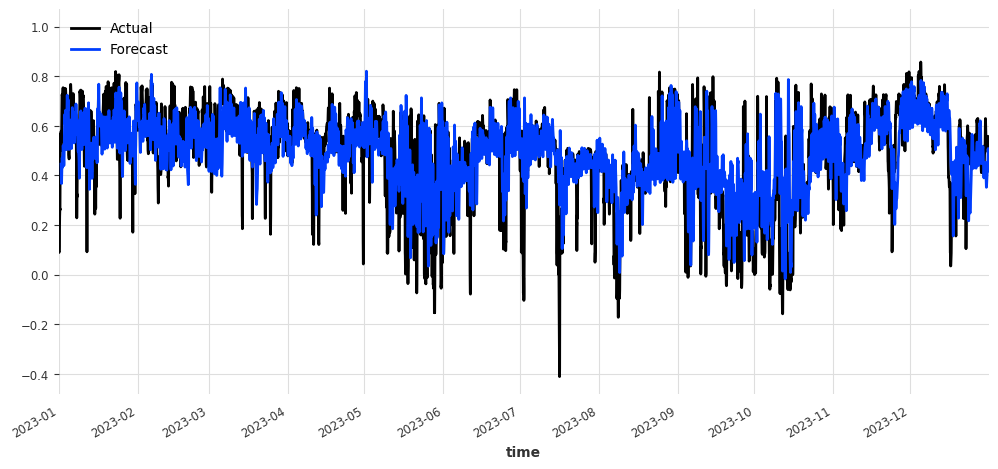

In [28]:
evaluate(lstm_model)

Comparison against the best model

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

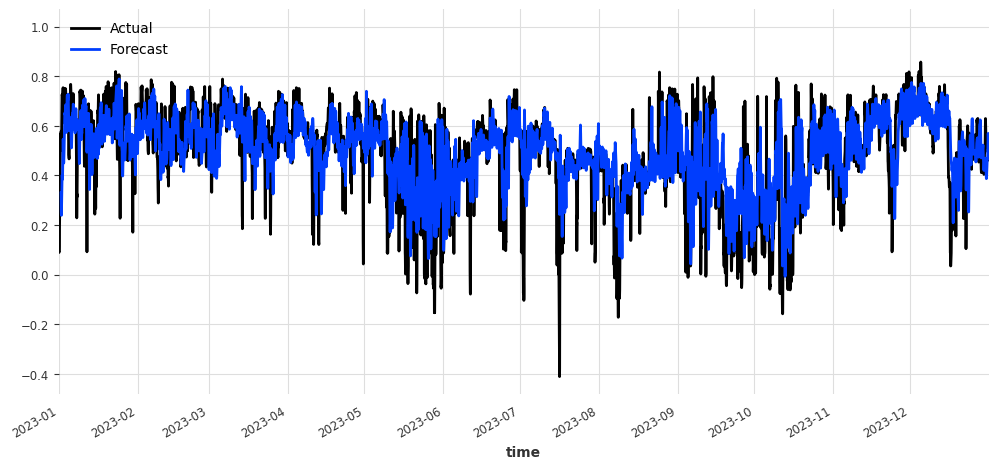

In [29]:
best_model = BlockRNNModel.load_from_checkpoint(model_name="LSTM_DayAheadPrices", best=True)
evaluate(best_model)

# Transform Back

In [31]:
from darts.metrics.metrics import _get_values_or_raise

def wmape(actual_series, pred_series):
  y_true, y_hat = _get_values_or_raise(actual_series, pred_series, intersect=True, remove_nan_union=True)
  return 100.0 * np.sum(np.abs(y_true - y_hat)) / np.sum(np.abs(y_true))

In [34]:
from darts.metrics import mape, rmse

def evaluate_transform_back(model):
  historical_forecasts = model.historical_forecasts(
    series_transformed,
    start=val_transformed.start_time(),
    forecast_horizon=24,
    past_covariates=covariates_past,
    retrain=False,
    enable_optimization=True,
    verbose=True
  )

  forecast = mlog.inverse_transform(
    compress.inverse_transform(
      historical_forecasts
    )
  )

  plt.figure(figsize=(12, 5))

  val.plot(label='Actual')
  forecast.plot(label='Transformed Forecast')

  plt.xlim(
    left=val.start_time(),
    right=val.end_time()
  )
  plt.title('wMAPE: {:.2f}%, MAPE: N/A, RMSE: {:.2f}'.format(wmape(val, forecast), rmse(val, forecast)))
  plt.legend()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

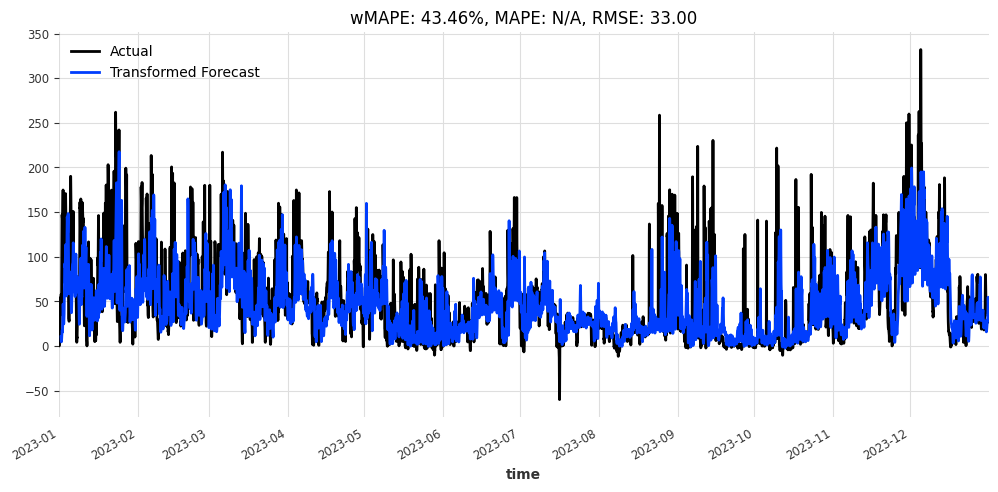

In [35]:
evaluate_transform_back(best_model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

(19416.958333333332, 19447.958333333332)

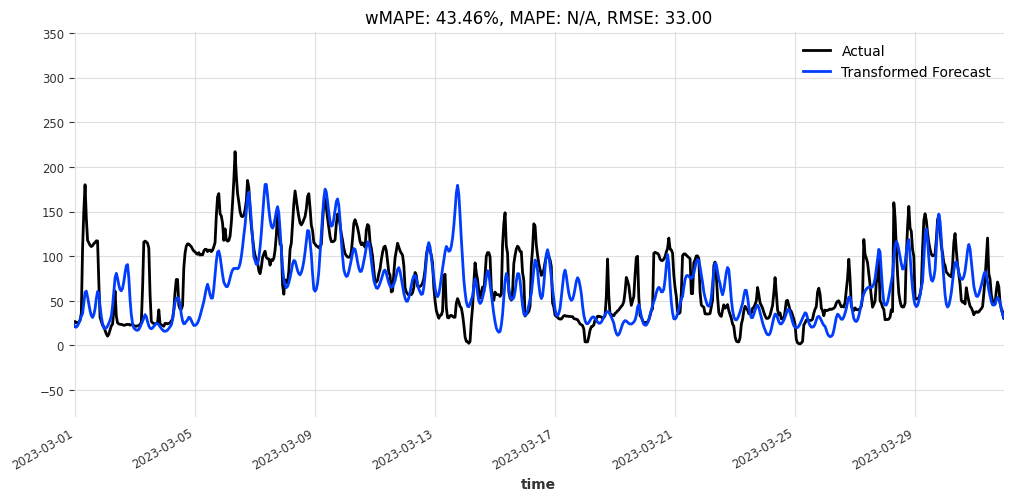

In [37]:
evaluate_transform_back(best_model)

plt.xlim(
  left=series.end_time() - pd.DateOffset(years=1) + pd.DateOffset(months=2),
  right=series.end_time() - pd.DateOffset(years=1) + pd.DateOffset(months=3)
)